In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

## Get the data

In [57]:
raw_data = pd.read_csv("../Data/abalone.data.csv",
                      names=['sex', 'lenght', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'vicerea_weight',
                            'shell_weight', 'rings'])

In [58]:
dataset = raw_data.copy()
dataset.tail()

,sex,lenght,diameter,height,whole_weight,shucked_weight,vicerea_weight,shell_weight,rings
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


## Inspect Data

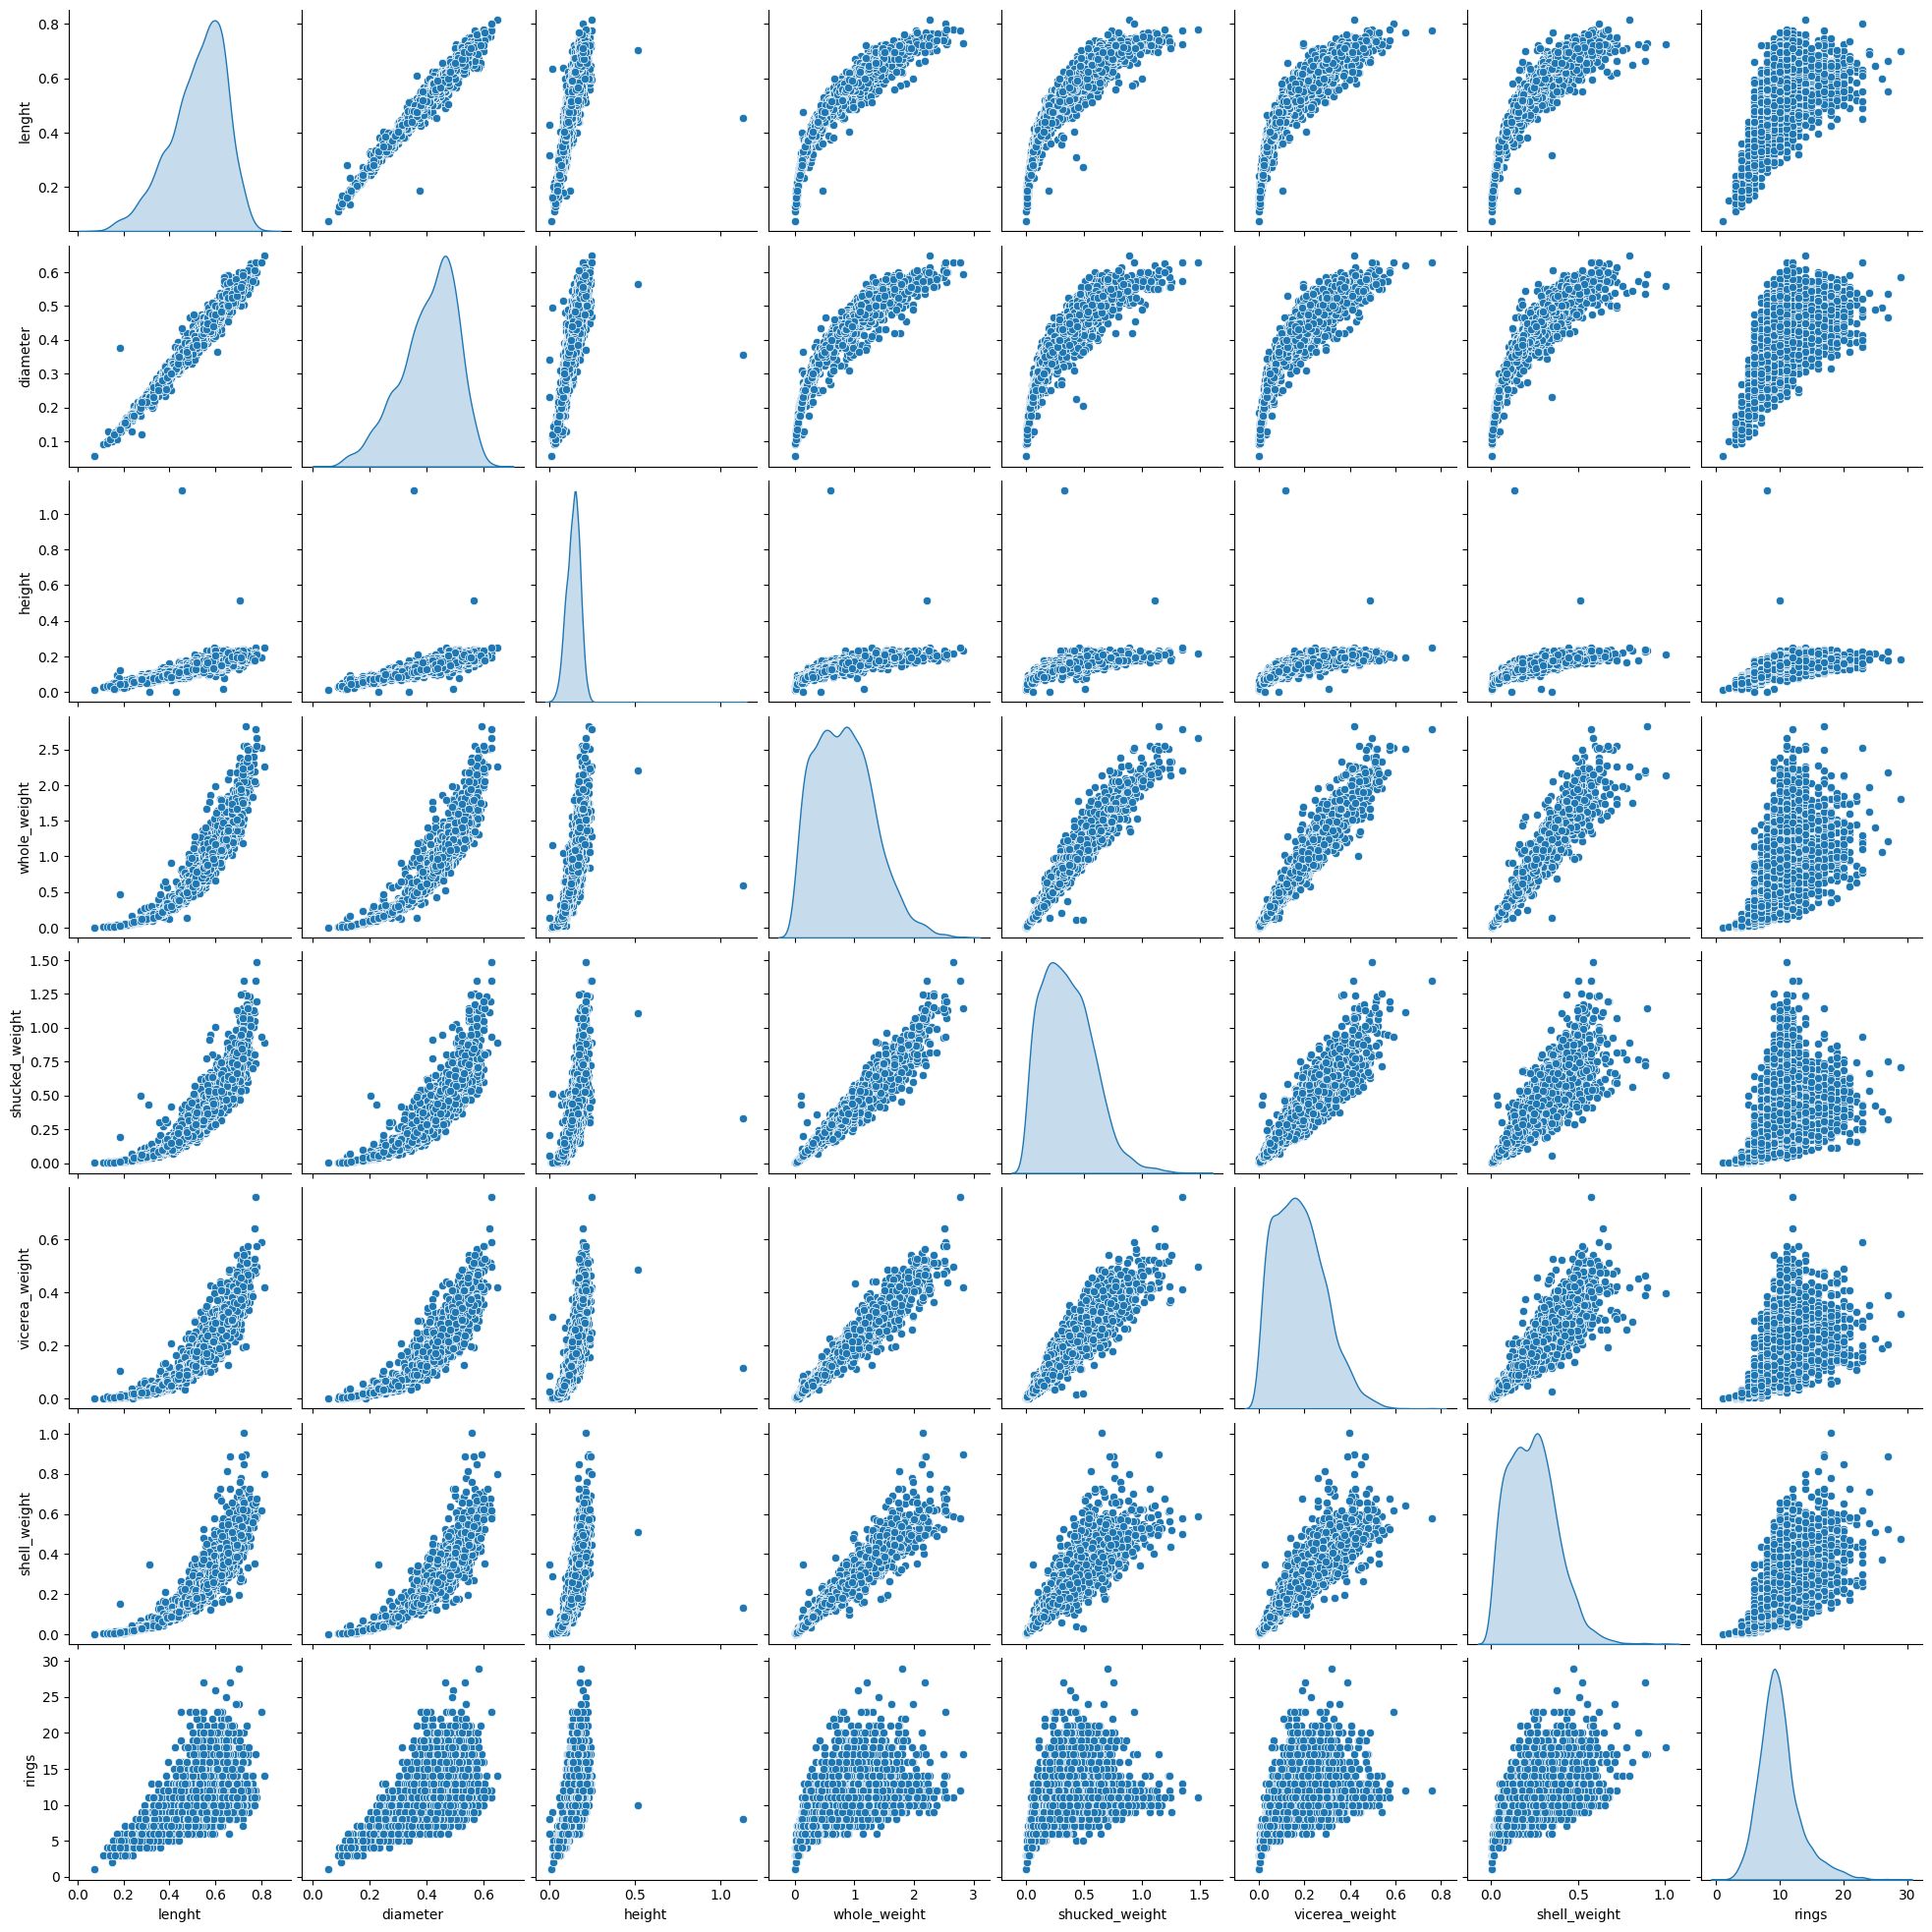

In [59]:
sns.pairplot(dataset[['lenght', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'vicerea_weight',
                      'shell_weight', 'rings']], diag_kind='kde')
plt.show()

## Feature eng

### Create label

In [60]:
dataset['ages'] = dataset['rings'] + 1.5

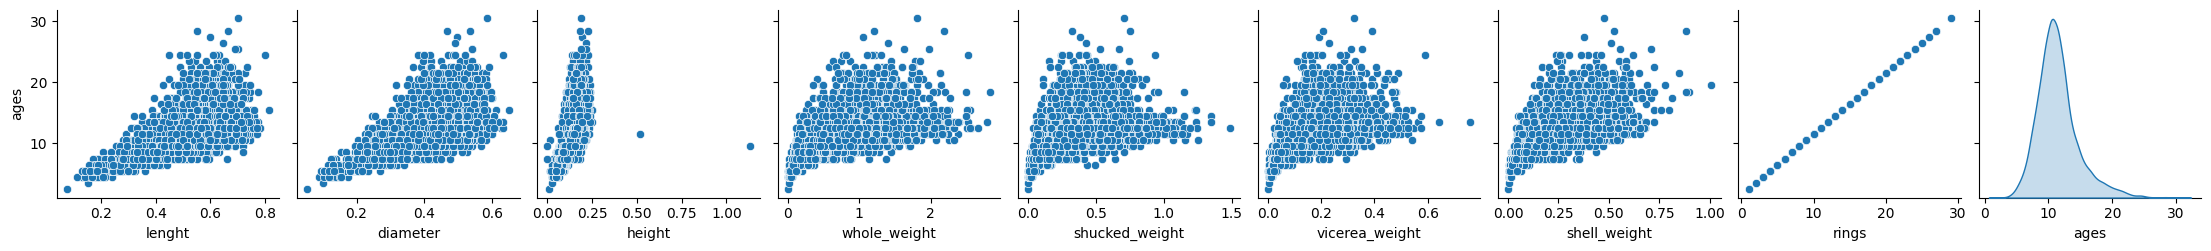

In [61]:
sns.pairplot(y_vars = ['ages'],
             x_vars = ['lenght', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'vicerea_weight',
                       'shell_weight', 'rings', 'ages'],
             data=dataset,
             diag_kind='kde')
plt.show()

### Dummy variable

In [62]:
transformer = make_column_transformer((OneHotEncoder(), ['sex']))

In [63]:
transformed = transformer.fit_transform(dataset)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [64]:
transformed_df

,onehotencoder__sex_F,onehotencoder__sex_I,onehotencoder__sex_M
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
4172,1.0,0.0,0.0
4173,0.0,0.0,1.0
4174,0.0,0.0,1.0
4175,1.0,0.0,0.0


In [65]:
dataset = pd.concat([dataset.drop(columns=['sex']), transformed_df], axis=1)

## Split Data

In [66]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

In [67]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("ages")
test_labels = test_features.pop("ages")

In [68]:
np.array(train_features)

array([[0.605, 0.455, 0.16 , ..., 0.   , 0.   , 1.   ],
       [0.59 , 0.44 , 0.15 , ..., 0.   , 0.   , 1.   ],
       [0.56 , 0.445, 0.195, ..., 1.   , 0.   , 0.   ],
       ...,
       [0.635, 0.525, 0.16 , ..., 0.   , 0.   , 1.   ],
       [0.445, 0.345, 0.09 , ..., 0.   , 0.   , 1.   ],
       [0.45 , 0.335, 0.105, ..., 1.   , 0.   , 0.   ]])

## Normalization Layer

In [69]:
normalizer = layers.Normalization(axis=-1)

In [70]:
normalizer.adapt(np.array(train_features))

In [72]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[0.6  0.46 0.16 1.1  0.42 0.3  0.33 9.   0.   0.   1.  ]]

Normalized: [[ 0.69  0.49  0.49  0.58  0.31  1.13  0.63 -0.28 -0.67 -0.69  1.32]]


## Linear Regression 

In [73]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

#### Try first prediction

In [74]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 108ms/step


array([[ 1.257],
       [ 0.911],
       [-1.776],
       [ 0.121],
       [-0.892],
       [-0.339],
       [ 0.466],
       [ 0.515],
       [-0.601],
       [-0.72 ]], dtype=float32)

Check weight of this model

In [75]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(11, 1) dtype=float32, numpy=
array([[-0.414],
       [ 0.53 ],
       [ 0.301],
       [ 0.577],
       [ 0.546],
       [ 0.253],
       [-0.252],
       [-0.547],
       [-0.624],
       [ 0.325],
       [ 0.116]], dtype=float32)>

#### Train the model

In [76]:
linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [78]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2)

d:\project_git\32 datasets uplift skills\env\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


In [83]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [age]')
    plt.legend()
    plt.grid(True)
    plt.show()

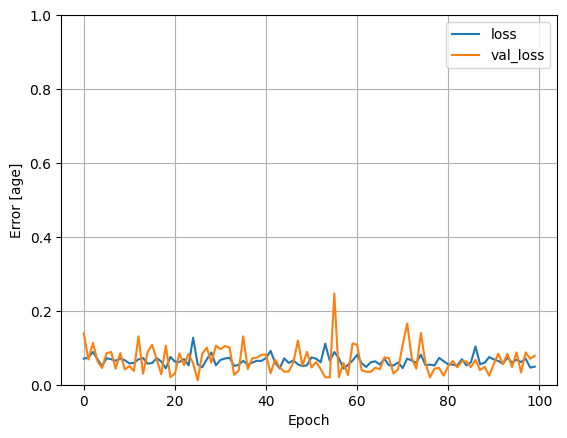

In [84]:
plot_loss(history)

#### Test result

In [98]:
error = linear_model.evaluate(
    test_features,
    test_labels,
    verbose=0)

In [99]:
print(f"MAPE: {error}")

MAPE: 0.06908892095088959


In [96]:
linear_model.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(11, 1) dtype=float32, numpy=
 array([[ 0.012],
        [ 0.024],
        [-0.007],
        [-0.004],
        [-0.003],
        [-0.01 ],
        [ 0.027],
        [ 3.335],
        [-0.003],
        [-0.013],
        [ 0.028]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([11.404], dtype=float32)>]